In [1]:
import tensorflow as tf
import json
import munch
import sde as eqn
import options as opts
from pricers import EarlyExercisePricer
from generate_data import create_dataset

# load config
sde_list = ["GBM", "TGBM", "SV", "SVJ", "HW"]
option_list = [
    "European",
    "EuropeanPut",
    "Lookback",
    "Asian",
    "Basket",
    "BasketnoPI",
    "Swap",
    "Bond",
    "Swaption",
    "TimeEuropean",
    "BermudanPut",
]
dim_list = [1, 3, 5, 10, 20]

sde_name = "HW"
option_name = "Swaption"
dim = 1

if (
    (sde_name not in sde_list)
    or (option_name not in option_list)
    or (dim not in dim_list)
):
    raise ValueError(
        f"please input right sde_name in {sde_list},\
                          option_name in {option_list} and dim in {dim_list}"
    )
else:
    json_path = f"./configs/{sde_name}_{option_name}_{dim}.json"
with open(json_path) as json_data_file:
    config = json.load(json_data_file)

config = munch.munchify(config)
initial_mode = config.eqn_config.initial_mode
kernel_type = config.net_config.kernel_type
sde = getattr(eqn, config.eqn_config.sde_name)(config)
option = getattr(opts, config.eqn_config.option_name)(config)

samples = config.eqn_config.sample_size
time_steps = config.eqn_config.time_steps
dims = config.eqn_config.dim
dataset_path = f"./dataset/{sde_name}_{option_name}_{dim}_{time_steps}"
create_dataset(sde_name, option_name, dim, 50)

# load dataset
dataset = tf.data.experimental.load(
    dataset_path,
    element_spec=(
        tf.TensorSpec(shape=(samples, time_steps + 1, 1)),
        tf.TensorSpec(shape=(samples, time_steps + 1, dims)),
        tf.TensorSpec(shape=(samples, time_steps, dims)),
        tf.TensorSpec(shape=(samples, time_steps + 1, 4)),
    ),
)
dataset = dataset.batch(config.eqn_config.batch_size)
test_dataset = dataset.take(10)
train_dataset = dataset.skip(10)
checkpoint_path = f"./checkpoint2/HW_bermudan/{sde_name}_{option_name}_{dim}"
# initialize the solver and train
pricer = EarlyExercisePricer(sde, option, config)
# tf.config.run_functions_eagerly(True)
pricer.fit(dataset, 40, checkpoint_path)
t = tf.reshape(
    tf.constant([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), [10, 1, 1, 1]
)
x = tf.reshape(
    tf.constant([0.052, 0.053, 0.055, 0.057, 0.058, 0.052, 0.053, 0.055, 0.057, 0.058]),
    [10, 1, 1, 1],
)
u = tf.reshape(
    tf.constant(
        [
            [0.4, 0.052, 0.03, 0.0],
            [0.4, 0.053, 0.03, 0.0],
            [0.4, 0.055, 0.03, 0.0],
            [0.4, 0.057, 0.03, 0.0],
            [0.4, 0.058, 0.03, 0.0],
            [0.4, 0.052, 0.05, 0.0],
            [0.4, 0.053, 0.05, 0.0],
            [0.4, 0.055, 0.05, 0.0],
            [0.4, 0.057, 0.05, 0.0],
            [0.4, 0.058, 0.05, 0.0],
        ]
    ),
    [10, 1, 1, 4],
)
y_pred = pricer.no_nets[0]((t, x, u))
dates = config.eqn_config.leg_dates
y_exact = option.zcp(0, x, u, dates[0]) - option.zcp(0, x, u, dates[-1])
print(y_pred, y_exact)
error = tf.reduce_mean(tf.abs((y_pred - y_exact)/y_exact))
print(error)


2023-10-30 16:51:31.864829: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.
(TensorSpec(shape=(50, 21, 1), dtype=tf.float32, name=None), TensorSpec(shape=(50, 21, 1), dtype=tf.float32, name=None), TensorSpec(shape=(50, 20, 1), dtype=tf.float32, name=None), TensorSpec(shape=(50, 21, 4), dtype=tf.float32, name=None))
Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.
=============begin 2 th interval============
Epoch 1/40
50/50 [==============================] - 27s 84ms/step - loss: 0.0138 - loss interior: 0.0131 - loss terminal: 7.0466e-04
Epoch 2/40
50/50 [==============================] - 4s 81ms/step - loss: 0.0097 - loss interior: 0.0092 - loss terminal: 5.0459e-04
Epoch 3/40
50/50 [==============================] - 4s 85ms/step - loss: 0.0017 - loss interior: 0.0016 - loss terminal: 8.4531e-05
Epoch 4/40
50/50 [==============================] - 4s 83ms/step - loss: 3.8263e-04 - loss interior: 3.6846e-04 - loss terminal: 1.4169e-05
Epoch 5/40
50/50 [=======================

In [2]:
for element in test_dataset.take(5):
    t, x, _, u = element
t0, x0, u0 = t[:, :, :11, :], x[:, :, :11, :], u[:, :, :11, :]
y_pred_0 = pricer.no_nets[0]((t0, x0, u0))
y_exact_0 = option.zcp(t0, x0, u0, 1) - option.zcp(t0, x0, u0, 3)
t1, x1, u1 = t[:, :, 11:, :], x[:, :, 11:, :], u[:, :, 11:, :]
y_pred_1 = pricer.no_nets[1]((t1, x1, u1))
y_exact_1 = option.zcp(t1, x1, u1, 2) - option.zcp(t1, x1, u1, 3)
y_pred, y_exact = tf.concat([y_pred_0, y_pred_1], axis=2), tf.concat([y_exact_0, y_exact_1], axis=2)
y_pred, y_exact, t = y_pred.numpy(), y_exact.numpy(), t.numpy()

print(pricer.no_nets)

[<function_space.DeepONet object at 0x7f97e86afd60>, <function_space.DeepONet object at 0x7f97e9165ab0>]


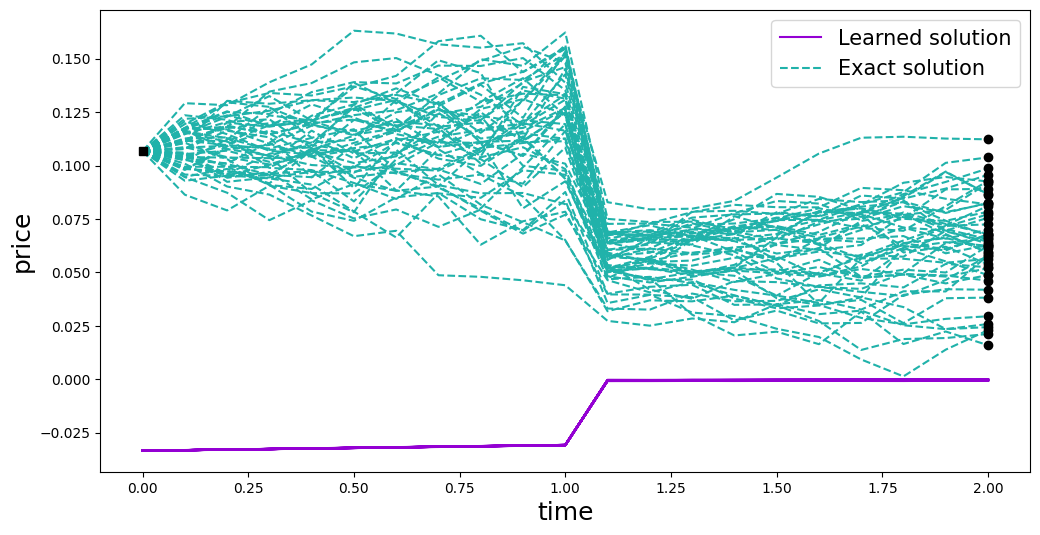

AttributeError: EagerTensor object has no attribute 'T'. 
        If you are looking for numpy-related methods, please run the following:
        tf.experimental.numpy.experimental_enable_numpy_behavior()
      

In [11]:
import matplotlib.pyplot as plt
def plot_mc_curves(y_pred, y_true, t_test, x_mc, u_hat):
    samples = 50
    plt.figure(figsize=(12, 6))
    plt.plot(t_test[0:1,:].T, y_pred[0:1,:].T,'darkviolet',label='Learned solution')
    plt.plot(t_test[0:1,:].T, y_true[0:1,:].T,'--',color='lightseagreen',label='Exact solution')
    plt.plot(t_test[0:1,-1], y_true[0:1,-1],'ko') #,label='$Y_T = u(T,X_T)$')

    plt.plot(t_test[1:samples,:].T, y_pred[1:samples,:].T,'darkviolet')
    plt.plot(t_test[1:samples,:].T, y_true[1:samples,:].T,'--',color='lightseagreen')
    plt.plot(t_test[1:samples,-1], y_true[1:samples,-1],'ko')

    plt.plot([0],y_true[0,0],'ks') # ,label='$Y_0 = u(0,X_0)$')

    plt.xlabel('time', fontdict={"size": 18})
    plt.ylabel('price', fontdict={"size": 18})
    #plt.title(fr'm={u_hat[-1]: 2f}, r={u_hat[0]: 2f}, $\theta$={u_hat[1]: 2f},$\kappa$={u_hat[2]: 2f}， $\sigma$={u_hat[3]: 2f}, $\rho$={u_hat[4]: 2f}')# , $\rho$={u_hat[2]: 2f}')
    plt.legend(prop={"size": 15})
    plt.show()
    plt.plot(t_test[1:samples,:].T, x_mc[1:samples, :, 0].T,'g',label='$X_t$')
idx_1 = 0
idx = 10
plot_mc_curves(y_pred[idx, :, :, 0], y_exact[idx, :, :, 0], t[idx, :, :, 0], x[idx], u[idx])

